In [ ]:
!pip install category_encoders

In [ ]:
!pip install pdpbox

In [ ]:
!pip install shap

In [ ]:
!pip install eli5

In [1]:
#구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
##라이브러리

#pandas
import pandas as pd

#시각화
import seaborn as sns
import matplotlib.pyplot as plt

from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

import numpy as np
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import f1_score

from ipywidgets import interact, fixed
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve

from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp
from pdpbox.pdp import pdp_interact, pdp_interact_plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


캐글 데이터
https://www.kaggle.com/subhamjain/loan-prediction-based-on-customer-behavior

# 1)

데이터 선정 이유: 회귀모델, 분류모델을 잘 활용하기 위해 타겟이 명확한 데이터를 선정했습니다.

알고자 하는 것: 고객의 나이, 직업, 수입 등 다양한 정보를 토대로 채무 불이행의 가능성이 있는지 판단하고자합니다.

In [3]:
#데이터 불러오기
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Training Data section2 proj.csv')

In [4]:
data = data.sample(frac=0.5, replace=False, random_state=2)

In [5]:
#데이터 갯수 확인
data.shape

(126000, 13)

Data Description
- Income: Income of the user   
- Age: Age of the user    
- Experience: Professional experience of the user in years    
- Profession: Profession   
- Married: Whether married or single   
- House_ownership: Owned or rented or neither.   
- Car_ownership: Does the person own a car	
- Currentjobyears: Years of experience in the current job	
- Currenthouseyears: Number of years in the current residence	 
- CITY: City of residence	
- SATATE: State of residence	
- risk_flag: Defaulted on a loan	

In [6]:
#타겟 설정
target = 'Risk_Flag'

In [7]:
#분류문제
'''
Risk_Flag : whether there has been a default(1) in the past or not(0).
'''

'\nRisk_Flag : whether there has been a default(1) in the past or not(0).\n'

# 2)

In [8]:
##클래스 별 갯수
##분류 클래스: 2개

proportion = data[target].value_counts()
proportion

0    110620
1     15380
Name: Risk_Flag, dtype: int64

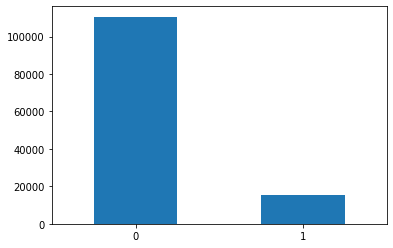

In [9]:
#클래스 갯수 시각화 
proportion.plot.bar()
plt.xticks([0,1],labels=['0', '1'], rotation=0)
plt.show()

In [10]:
##클래스 비율
data[target].value_counts(normalize=True)
#majority class 비율이 87%로 매우 크기 때문에 accuracy가 아닌 AUC score, f1 score를 활용해야 할 것 같다.

0    0.877937
1    0.122063
Name: Risk_Flag, dtype: float64

majority class 비율이 88%로 매우 크기 때문에 accuracy가 아닌 AUC score, f1 score를 활용해야 할 것 같다.

Recall과 Precision중 어떤 것을 중점적으로 봐야할지 고민했으나, 도메인 지식 부족으로 f1 score를 보기로 했다.

# 3)

In [11]:
#null값 확인
data.isnull().sum()

Id                   0
Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

In [12]:
data.dtypes

Id                    int64
Income                int64
Age                   int64
Experience            int64
Married/Single       object
House_Ownership      object
Car_Ownership        object
Profession           object
CITY                 object
STATE                object
CURRENT_JOB_YRS       int64
CURRENT_HOUSE_YRS     int64
Risk_Flag             int64
dtype: object

In [13]:
#high cardinality 확인
data.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
Married/Single,126000,2,single,113084
Car_Ownership,126000,2,no,87985
House_Ownership,126000,3,rented,116057
STATE,126000,29,Uttar_Pradesh,14291
Profession,126000,51,Physician,2924
CITY,126000,317,Vijayanagaram,633


- cardinality가 매우 높은 city는 drop
- 분류문제로, 포레스트 모델을 사용할 예정이기 때문에 ordinal encoding할 계획


In [14]:
#데이터 전처리
def engineer(df):


    ##1. 나이 범위
    #나이 확인
    df['Age'].value_counts().sort_index() #21세~79세
    #범위 및 범위이름 지정
    bins = [20, 30, 40, 50, 60, 70, 80]
    labels = [20, 30, 40, 50, 60, 70]
    #'Age Group' feature 생성
    df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
    ###### 나이 범위 더 넓게 합쳐야 할까?
    
    #city제거
    df = df.drop('CITY', axis=1)
    
    #id 제거
    df = df.drop('Id', axis=1)

    return df


data = engineer(data)

In [15]:
data

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Age Group
221926,5653048,61,16,single,rented,no,Graphic_Designer,Gujarat,11,13,0,60
212087,156145,69,7,single,rented,yes,Web_designer,West_Bengal,7,13,1,60
251277,4498227,53,18,married,rented,no,Chef,Puducherry,9,11,0,50
223297,3230139,60,11,single,rented,yes,Comedian,Uttar_Pradesh,8,11,0,60
238193,7429551,21,3,single,rented,no,Computer_hardware_engineer,Bihar,3,10,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...
208858,8940384,33,10,single,rented,no,Secretary,Maharashtra,6,12,0,30
205043,5895669,42,9,single,rented,no,Financial_Analyst,Bihar,9,11,0,40
162467,1306929,66,14,single,rented,no,Engineer,Karnataka,11,10,0,60
79663,9474065,73,11,single,rented,no,Graphic_Designer,Jharkhand,3,11,0,70


# 4)


In [16]:


#테스트 데이터 나누기
train_val, test = train_test_split(data, test_size=0.20, random_state=2)

#검증 데이터 나누기
train, val = train_test_split(train_val, test_size=0.20, random_state=2)

X_train = train.drop(columns=target)
y_train = train[target]

X_val = val.drop(columns=target)
y_val = val[target]

X_test = test.drop(columns=target)
y_test = test[target]

In [17]:
X_train

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Age Group
36569,3625101,28,5,single,rented,no,Comedian,West_Bengal,5,10,20
127959,2770155,64,9,single,rented,yes,Chartered_Accountant,Uttar_Pradesh,9,10,60
175736,9605093,25,7,single,rented,no,Librarian,Manipur,7,12,20
136767,3248934,40,10,single,rented,no,Computer_hardware_engineer,West_Bengal,10,12,40
154802,1591827,21,13,single,norent_noown,no,Web_designer,Delhi,4,12,20
...,...,...,...,...,...,...,...,...,...,...,...
245174,9457317,38,12,single,rented,no,Hotel_Manager,Maharashtra,9,14,30
215683,4753619,56,2,single,rented,no,Graphic_Designer,Andhra_Pradesh,2,12,50
58647,6147575,41,15,single,rented,yes,Hotel_Manager,West_Bengal,4,12,40
155376,9028969,62,19,single,rented,yes,Industrial_Engineer,Tamil_Nadu,4,10,60


In [18]:

###baseline model
major = y_train.mode()[0]

#타겟 샘플 수 만큼 0이 담긴 리스트
y_pred_base_train = [major] * len(y_train)
y_pred_base_val = [major] * len(y_val)


#기준모델 accuracy score
print("training accuracy_score: ", accuracy_score(y_train, y_pred_base_train))
print("validation accuracy_score: ", accuracy_score(y_val, y_pred_base_val))

#기준모델 f1 score
print("training f1_score: ", f1_score(y_train, y_pred_base_train))
print("validation f1_score: ", f1_score(y_val, y_pred_base_val))


training accuracy_score:  0.8777777777777778
validation accuracy_score:  0.8779761904761905
training f1_score:  0.0
validation f1_score:  0.0


- 클래스 불균형이 심하기 때문에 accuracy score는 높지만 f1 score는 0.0이 나왔다.
- 위 모델을 베이스라인 모델로 선정하는 것은 타당하지 않아보인다.
- 기본적인 하이퍼파라미터를 조정한 모델을 베이스라인 모델로 선정하는 것이 타당해 보인다.



---



In [ ]:
##기본모델

In [19]:
##기본 모델 1(random forest)
pipe1 = make_pipeline(OrdinalEncoder(),
                      RandomForestClassifier(random_state=2, class_weight='balanced'))#가중치 조절

pipe1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Married/Single', 'House_Ownership',
                                      'Car_Ownership', 'Profession', 'STATE',
                                      'Age Group'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Married/Single',
                                          'data_type': dtype('O'),
                                          'mapping': single     1
married    2
NaN       -2
dtype: int64},
                                         {'col': 'House_Ownership',
                                          'data_ty...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                               

In [20]:
#기본 모델1 결과
y_pred1 = pipe1.predict(X_val)

print('\n <validation 정확도> \n', accuracy_score(y_val, y_pred1))

print("\n <classification_report> \n ", classification_report(y_pred1, y_val))

print("\n <f1 score> \n ", f1_score(y_pred1, y_val))


 <validation 정확도> 
 0.8936011904761905

 <classification_report> 
                precision    recall  f1-score   support

           0       0.91      0.96      0.94     16803
           1       0.75      0.55      0.63      3357

    accuracy                           0.89     20160
   macro avg       0.83      0.75      0.78     20160
weighted avg       0.89      0.89      0.89     20160


 <f1 score> 
  0.631253223310985


In [21]:
##기본 모델2(xgboost)

vc = y_train.value_counts().tolist()
vc

[70784, 9856]

In [22]:
#클래스 불균형 비율
ratio = float(vc[0]/vc[1])
ratio

7.181818181818182

In [23]:
##기본 모델2(xgboost)
pipe2 = make_pipeline(OrdinalEncoder(), XGBClassifier(random_state=2, scale_pos_weight = ratio))

pipe2.fit(X_train, y_train);

In [24]:
#기본 모델2 결과
y_pred2 = pipe2.predict(X_val)

print('\n <validation 정확도> \n', accuracy_score(y_val, y_pred2))

print("\n <classification_report> \n ", classification_report(y_pred2, y_val))

print("\n <f1 score> \n ", f1_score(y_pred2, y_val))


 <validation 정확도> 
 0.6277777777777778

 <classification_report> 
                precision    recall  f1-score   support

           0       0.64      0.91      0.75     12404
           1       0.55      0.17      0.27      7756

    accuracy                           0.63     20160
   macro avg       0.59      0.54      0.51     20160
weighted avg       0.60      0.63      0.56     20160


 <f1 score> 
  0.2654659357870008


- 기본적이 하이퍼파라미터만 조정했을 때, Gradient boosting(0.265)보다는 Random Forest(0.631)가 더 성능이 좋다.

In [ ]:
##간단한 하이퍼파라미터 조정

In [25]:
##모델 1(n_estimators=100)
model1 = make_pipeline(OrdinalEncoder(),
                      RandomForestClassifier(random_state=2, 
                                             class_weight='balanced',
                                             n_estimators=100,
                                             n_jobs=-1))

model1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Married/Single', 'House_Ownership',
                                      'Car_Ownership', 'Profession', 'STATE',
                                      'Age Group'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Married/Single',
                                          'data_type': dtype('O'),
                                          'mapping': single     1
married    2
NaN       -2
dtype: int64},
                                         {'col': 'House_Ownership',
                                          'data_ty...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                               

In [26]:
#모델1 결과
y_pred_m1 = model1.predict(X_val)

print('\n <validation 정확도> \n', accuracy_score(y_val, y_pred_m1))

print("\n <classification_report> \n ", classification_report(y_pred_m1, y_val))

print("\n <f1 score> \n ", f1_score(y_pred_m1, y_val))


 <validation 정확도> 
 0.8936011904761905

 <classification_report> 
                precision    recall  f1-score   support

           0       0.91      0.96      0.94     16803
           1       0.75      0.55      0.63      3357

    accuracy                           0.89     20160
   macro avg       0.83      0.75      0.78     20160
weighted avg       0.89      0.89      0.89     20160


 <f1 score> 
  0.631253223310985


In [27]:
##모델 2(max_depth=20으로 조정)
model2 = make_pipeline(OrdinalEncoder(),
                      RandomForestClassifier(random_state=2, 
                                             class_weight='balanced',
                                             max_depth=20))

model2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Married/Single', 'House_Ownership',
                                      'Car_Ownership', 'Profession', 'STATE',
                                      'Age Group'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Married/Single',
                                          'data_type': dtype('O'),
                                          'mapping': single     1
married    2
NaN       -2
dtype: int64},
                                         {'col': 'House_Ownership',
                                          'data_ty...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=20,
                                 

In [28]:
#모델2 결과
y_pred_m2 = model2.predict(X_val)

print('\n <validation 정확도> \n', accuracy_score(y_val, y_pred_m2))

print("\n <classification_report> \n ", classification_report(y_pred_m2, y_val))

print("\n <f1 score> \n ", f1_score(y_pred_m2, y_val))


 <validation 정확도> 
 0.8928075396825397

 <classification_report> 
                precision    recall  f1-score   support

           0       0.91      0.96      0.94     16805
           1       0.74      0.54      0.63      3355

    accuracy                           0.89     20160
   macro avg       0.83      0.75      0.78     20160
weighted avg       0.89      0.89      0.89     20160


 <f1 score> 
  0.6283748925193464


In [29]:
##모델 3(min_samples_leaf=18로 조정)
model3 = make_pipeline(OrdinalEncoder(),
                      RandomForestClassifier(random_state=2, 
                                             class_weight='balanced',
                                             min_samples_leaf=18))

model3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Married/Single', 'House_Ownership',
                                      'Car_Ownership', 'Profession', 'STATE',
                                      'Age Group'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Married/Single',
                                          'data_type': dtype('O'),
                                          'mapping': single     1
married    2
NaN       -2
dtype: int64},
                                         {'col': 'House_Ownership',
                                          'data_ty...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                               

In [31]:
#모델3 결과
y_pred_m3 = model3.predict(X_val)

print("\n <classification_report> \n ", classification_report(y_pred_m3, y_val))

print("\n <f1 score> \n ", f1_score(y_pred_m3, y_val))


 <classification_report> 
                precision    recall  f1-score   support

           0       0.91      0.96      0.93     16670
           1       0.75      0.53      0.62      3490

    accuracy                           0.89     20160
   macro avg       0.83      0.75      0.78     20160
weighted avg       0.88      0.89      0.88     20160


 <f1 score> 
  0.6211764705882352


- random forest의 경우, 하이퍼파라미터를 하나씩 조정해봤다.
  - 모델 1(n_estimators=100으로 조정) : 0.631
  - 모델 2(max_depth=20으로 조정) : 0.628
  - 모델 3(min_samples_leaf=18로 조정) : 0.621
- 그 결과값을 보니, 기본 모델(0.631)과 큰 차이는 없다.
- randomized search cv를 해볼 예정이지만 성능에 큰 변화가 있을것으로 기대되진 않는다.

In [32]:
#모델4(xgboost)
#하이퍼파라미터를 조정해보니 성능이 많이 올라 살펴보기로 결정
model4 = make_pipeline(OrdinalEncoder(), XGBClassifier(random_state=2, scale_pos_weight = ratio,
                                                      n_jobs=-1, max_depth=7, 
                                                       n_estimators=1000, learning_rate=0.3))

model4.fit(X_train, y_train);

In [33]:
#기본 모델4 결과
y_pred4 = model4.predict(X_val)

print('\n <validation 정확도> \n', accuracy_score(y_val, y_pred4))

print("\n <classification_report> \n ", classification_report(y_pred4, y_val))

print("\n <f1 score> \n ", f1_score(y_pred4, y_val))


 <validation 정확도> 
 0.8882936507936507

 <classification_report> 
                precision    recall  f1-score   support

           0       0.90      0.97      0.93     16584
           1       0.77      0.53      0.63      3576

    accuracy                           0.89     20160
   macro avg       0.84      0.75      0.78     20160
weighted avg       0.88      0.89      0.88     20160


 <f1 score> 
  0.6269052352551359


- 반면, xgboost의 경우 하이퍼파라미터의 조정으로 성능에 큰 차이가 있었다.
  - 기본모델: 0.265
  - 모델4 :  0.626



---




In [ ]:
##randomizedsearch cv

In [ ]:


#randomforest randomizedsearch cv

model_randf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=2, class_weight='balanced')
)

param_randf = {
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__n_estimators': [50, 100, 1000],
    'randomforestclassifier__min_samples_split': [8, 12, 16, 20, None],
}

clf_randf = RandomizedSearchCV(
    model_randf,
    param_distributions=param_randf,
    n_iter=50,
    cv=8,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

clf_randf.fit(X_train, y_train);

## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
  display(Audio(url='https://freesound.org/data/previews/219/219244_4082826-lq.mp3', autoplay=True))
## Insert whatever audio file you want above
allDone()


#####최적 하이퍼파라미터:  {'randomforestclassifier__n_estimators': 1000, 
#####              'randomforestclassifier__min_samples_split': 8, 
#####              'randomforestclassifier__max_depth': None}
##### 시간 부족해서 다시 못실행함

In [ ]:
print('최적 하이퍼파라미터: ', clf_randf.best_params_)
print('f1: ', clf_randf.best_score_)

In [35]:
# 최적 하이퍼파라미터로 학습 -> validation dataset score
pipe = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=1000, 
                           random_state=2, 
                           class_weight='balanced',
                           n_jobs=-1, 
                           min_samples_split=8))

pipe .fit(X_train, y_train);

y_pred_pipe = pipe.predict(X_val)
f1_pipe = f1_score(y_val, y_pred_pipe)
print(f'최적의 하이퍼 파라미터로 학습을 했을 때 검증세트 f1:{f1_pipe}')

최적의 하이퍼 파라미터로 학습을 했을 때 검증세트 f1:0.6304049416609471


In [36]:
# 가장 최고의 모델로 학습 -> validation dataset score
best_model_randf = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=100, 
                           random_state=2, 
                           class_weight='balanced',
                           n_jobs=-1, 
                           min_samples_split=8))

best_model_randf.fit(X_train, y_train);

y_pred_randf = best_model_randf.predict(X_val)
f1_randf = f1_score(y_val, y_pred_randf)
print(f'최적의 하이퍼파라미터를 수정했을 때 검증세트 f1:{f1_randf}')

최적의 하이퍼파라미터를 수정했을 때 검증세트 f1:0.6320835473377847


- Randomized search cv의 성능(0.630)보다 모델1의 성능(0.631)이 더 좋다.
- Randomized search cv의 최적의 하이퍼파라미터 중 n_estimator만 모델1과 같게 수정한 후 성능을 봐보니, 수정한 모델의 성능이 더 좋게 나왔다.
  - 모델1의 f1 score: 0.631
  - 최적의 하이퍼파라미터 모델 f1 socre: 0.630
  - 수정 후 f1 score: 0.632



---



In [ ]:
#xgboost randomizedsearch cv

In [37]:
#xgboost early stopping
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model_xgb = XGBClassifier(random_state=2,
                          scale_pos_weight = ratio,
                          n_jobs=-1, 
                          max_depth=15, 
                          learning_rate=0.3,
                          n_estimators= 1000)

eval_set = [(X_train_encoded, y_train),
            (X_val_encoded, y_val)]

model_xgb.fit(X_train_encoded, y_train,
              eval_set=eval_set,
              eval_metric='error',
              early_stopping_rounds=100)


[0]	validation_0-error:0.192857	validation_1-error:0.221825
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.161992	validation_1-error:0.193948
[2]	validation_0-error:0.121962	validation_1-error:0.160317
[3]	validation_0-error:0.11529	validation_1-error:0.153869
[4]	validation_0-error:0.109065	validation_1-error:0.149058
[5]	validation_0-error:0.101625	validation_1-error:0.142312
[6]	validation_0-error:0.095362	validation_1-error:0.136409
[7]	validation_0-error:0.091381	validation_1-error:0.131349
[8]	validation_0-error:0.086062	validation_1-error:0.126687
[9]	validation_0-error:0.083209	validation_1-error:0.123909
[10]	validation_0-error:0.081882	validation_1-error:0.12252
[11]	validation_0-error:0.08027	validation_1-error:0.121131
[12]	validation_0-error:0.079812	validation_1-error:0.120982
[13]	validation_0-error:0.078745	validation_1-error:0.1199

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7.181818181818182,
              seed=None, silent=None, subsample=1, verbosity=1)

In [38]:
print(classification_report(y_val, model_xgb.predict(X_val_encoded)))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     17700
           1       0.54      0.76      0.63      2460

    accuracy                           0.89     20160
   macro avg       0.75      0.84      0.78     20160
weighted avg       0.91      0.89      0.90     20160



In [39]:
y_pred_xgb = model_xgb.predict(X_val_encoded)
f1_xgb = f1_score(y_val, y_pred_xgb)
print(f'검증세트 f1:{f1_xgb}')

검증세트 f1:0.6293565683646113


- xgboost의 경우 early stopping을 사용해보니, 성능이 향상됐다.
  - 모델4 f1 score:  0.626
  - early stopping모델 f1 score: 0.629



---



---



현재까지의 성능을 살펴보면,
- Random Forest 검증세트
  - 수정된 RandomizedSearch CV의 f1: 0.632 (best_model_randf)
  - 기본모델의 f1: 0.631 (model1)
- Gradient Boosting 검증세트의 f1: 0.628 (model_xgb)

수정된 RandomizedSearch CV의 성능이 가장 좋아보인다.

In [ ]:
##ROC Curve, AUC

In [40]:
#RandomizedSearchCV모델의 클래스별 예측 확률
best_model_randf.predict_proba(X_val)

array([[0.77863303, 0.22136697],
       [0.98679857, 0.01320143],
       [1.        , 0.        ],
       ...,
       [1.        , 0.        ],
       [0.76904643, 0.23095357],
       [0.76604955, 0.23395045]])

In [41]:
#RandomizedSearchCV모델의 positive예측 확률
y_pred_proba_1 = best_model_randf.predict_proba(X_val)[:, 1]
y_pred_proba_1

array([0.22136697, 0.01320143, 0.        , ..., 0.        , 0.23095357,
       0.23395045])

In [42]:
#임계값 조정하며 precision, recall, f1_score확인

def explore_threshold1(y_true, y_pred_proba_1, threshold=0.5):
    y_pred = y_pred_proba_1 >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba_1, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold1, 
    y_true=fixed(y_val), 
    y_pred_proba_1=fixed(y_pred_proba_1), 
    threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

- 임계값을 조정해보니, 0.5가 가장 적당해보인다.

In [43]:
# roc_curve(타겟값, prob of 1)
fpr1, tpr1, thresholds1 = roc_curve(y_val, y_pred_proba_1)

roc1 = pd.DataFrame({
    'FPR(Fall-out)': fpr1, 
    'TPRate(Recall)': tpr1, 
    'Threshold': thresholds1
})
roc1

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,2.000000
1,0.000000,0.000813,1.000000
2,0.000113,0.001220,0.998488
3,0.000169,0.001220,0.997195
4,0.000226,0.001626,0.996738
...,...,...,...
3097,0.696045,1.000000,0.003391
3098,0.696610,1.000000,0.003238
3099,0.696836,1.000000,0.003098
3100,0.697119,1.000000,0.002970


In [44]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx1 = np.argmax(tpr1 - fpr1)
optimal_threshold1 = thresholds1[optimal_idx1]

print('idx:', optimal_idx1, ', threshold:', optimal_threshold1)

idx: 1981 , threshold: 0.08385429264702529


In [45]:
#임계값 0.5일때의 score
y_pred_05 = y_pred_proba_1 >= 0.5
print(classification_report(y_val, y_pred_05))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94     17700
           1       0.55      0.75      0.63      2460

    accuracy                           0.89     20160
   macro avg       0.75      0.83      0.78     20160
weighted avg       0.91      0.89      0.90     20160



In [46]:
#최적의 임계값일때의 score
y_pred_optimal = y_pred_proba_1 >= optimal_threshold1
print(classification_report(y_val, y_pred_optimal))

              precision    recall  f1-score   support

           0       1.00      0.78      0.87     17700
           1       0.38      1.00      0.55      2460

    accuracy                           0.80     20160
   macro avg       0.69      0.89      0.71     20160
weighted avg       0.92      0.80      0.84     20160



In [56]:
#임계값을 조절했을 때, recall 값이 1.00으로 나오고, f1값은 떨어진다.
#정확하게 어떤것을 의미하는 바인지 아직 잘 모르겠다.
#f1값을 보기로 결정했으니, f1값이 높은 것을 선택하기로 결정했다.

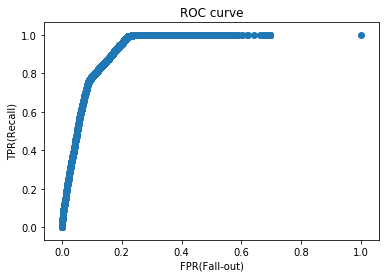

In [47]:
#roc curve
plt.scatter(fpr1, tpr1)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [48]:
#AUC

auc_score_1 = roc_auc_score(y_val, y_pred_proba_1)
print('ACU:',auc_score_1)

ACU: 0.9330669353727434




---



In [ ]:
#모델_1

In [49]:
model1.predict_proba(X_val)

array([[0.80864512, 0.19135488],
       [1.        , 0.        ],
       [1.        , 0.        ],
       ...,
       [1.        , 0.        ],
       [0.8007933 , 0.1992067 ],
       [0.83760461, 0.16239539]])

In [50]:
y_pred_proba_2 = model1.predict_proba(X_val)[:, 1]
y_pred_proba_2

array([0.19135488, 0.        , 0.        , ..., 0.        , 0.1992067 ,
       0.16239539])

In [51]:
def explore_threshold2(y_true, y_pred_proba_2, threshold=0.5):
    y_pred = y_pred_proba_2 >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba_2, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold2, 
    y_true=fixed(y_val), 
    y_pred_proba_2=fixed(y_pred_proba_2), 
    threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [52]:
# roc_curve(타겟값, prob of 2)
fpr2, tpr2, thresholds2 = roc_curve(y_val, y_pred_proba_2)

roc2 = pd.DataFrame({
    'FPR(Fall-out)': fpr2, 
    'TPRate(Recall)': tpr2, 
    'Threshold': thresholds2
})
roc2

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,2.000000
1,0.000282,0.007317,1.000000
2,0.000282,0.008537,0.991748
3,0.000339,0.009350,0.990000
4,0.000339,0.010569,0.989851
...,...,...,...
1997,0.230056,0.998780,0.007966
1998,0.230395,0.998780,0.007822
1999,0.230565,0.998780,0.007548
2000,0.230791,0.998780,0.005896


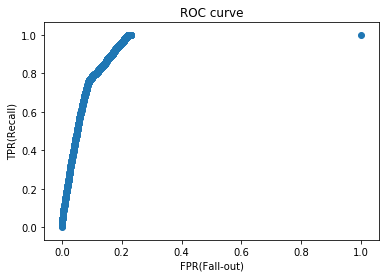

In [53]:
plt.scatter(fpr2, tpr2)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [54]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx2 = np.argmax(tpr2 - fpr2)
optimal_threshold2 = thresholds2[optimal_idx2]

print('idx:', optimal_idx2, ', threshold:', optimal_threshold2)

idx: 1979 , threshold: 0.02509428389676481


In [55]:
#AUC
auc_score_2 = roc_auc_score(y_val, y_pred_proba_2)
print('ACU:',auc_score_2)

ACU: 0.9329517707041478




---



In [ ]:
#model_xgb

In [56]:
model_xgb.predict_proba(X_val_encoded)

array([[9.9745411e-01, 2.5458944e-03],
       [9.9906766e-01, 9.3232992e-04],
       [9.9901968e-01, 9.8032714e-04],
       ...,
       [9.9800670e-01, 1.9932778e-03],
       [9.9641412e-01, 3.5858916e-03],
       [9.5368373e-01, 4.6316296e-02]], dtype=float32)

In [57]:
y_pred_proba_3 = model_xgb.predict_proba(X_val_encoded)[:, 1]
y_pred_proba_3

array([0.00254589, 0.00093233, 0.00098033, ..., 0.00199328, 0.00358589,
       0.0463163 ], dtype=float32)

In [58]:
def explore_threshold3(y_true, y_pred_proba_3, threshold=0.5):
    y_pred = y_pred_proba_3 >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba_3, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold3, 
    y_true=fixed(y_val), 
    y_pred_proba_3=fixed(y_pred_proba_3), 
    threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [59]:
# roc_curve(타겟값, prob of 3)
fpr3, tpr3, thresholds3 = roc_curve(y_val, y_pred_proba_3)

roc3 = pd.DataFrame({
    'FPR(Fall-out)': fpr3, 
    'TPRate(Recall)': tpr3, 
    'Threshold': thresholds3
})
roc3

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.999669
1,0.000000,0.000813,0.999669
2,0.000113,0.001220,0.999552
3,0.000113,0.002439,0.999421
4,0.000169,0.002439,0.999141
...,...,...,...
6025,0.999379,1.000000,0.000032
6026,0.999548,1.000000,0.000030
6027,0.999774,1.000000,0.000027
6028,0.999944,1.000000,0.000020


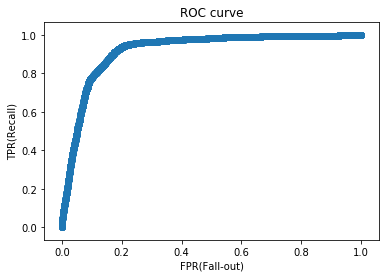

In [60]:
plt.scatter(fpr3, tpr3)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [61]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx3 = np.argmax(tpr3 - fpr3)
optimal_threshold3 = thresholds3[optimal_idx3]

print('idx:', optimal_idx3, ', threshold:', optimal_threshold3)

idx: 1819 , threshold: 0.0060815765


In [62]:
#AUC
auc_score_3 = roc_auc_score(y_val, y_pred_proba_3)
print('ACU:',auc_score_3)

ACU: 0.9200621124431584


- AUC scored에서 RandomizedSearch CV모델이 더 높았다.
  - RandomizedSearch CV모델의 AUC: 0.933
  - 기본 모델의 AUC: 0.932
  - XGBoose모델의 AUC: 0.920



---




In [ ]:
#confusion matrix

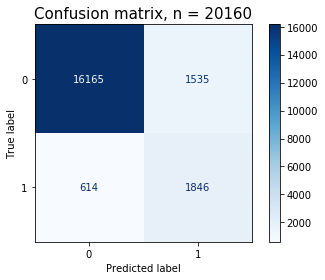

In [63]:
#confusion matrix

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(best_model_randf, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax, values_format='');
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()



---



---



In [64]:
# permuter 정의
permuter = PermutationImportance(
    best_model_randf.named_steps['randomforestclassifier'],
    scoring='accuracy', 
    n_iter=5,
    random_state=2
)

X_val_transformed = best_model_randf.named_steps['ordinalencoder'].transform(X_val)

permuter.fit(X_val_transformed, y_val);

In [65]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

Car_Ownership       -0.000933
House_Ownership     -0.000040
Married/Single       0.000615
Age Group            0.001498
CURRENT_HOUSE_YRS    0.003085
Experience           0.005734
Income               0.005823
Profession           0.006806
CURRENT_JOB_YRS      0.007103
STATE                0.007292
Age                  0.010714
dtype: float64

In [66]:
# 특성별 score 확인
permutation = eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)
permutation

Weight,Feature
0.0107 ± 0.0023,Age
0.0073 ± 0.0029,STATE
0.0071 ± 0.0017,CURRENT_JOB_YRS
0.0068 ± 0.0028,Profession
0.0058 ± 0.0014,Income
0.0057 ± 0.0028,Experience
0.0031 ± 0.0021,CURRENT_HOUSE_YRS
0.0015 ± 0.0019,Age Group
0.0006 ± 0.0011,Married/Single
-0.0000 ± 0.0011,House_Ownership


In [67]:
minimum_importance = 0.002
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]

In [68]:
print('특성 삭제 후:', X_train_selected.shape, X_val_selected.shape)

특성 삭제 후: (80640, 7) (20160, 7)


In [69]:
best_model_randf_selected = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=100, 
                           random_state=2, 
                           class_weight='balanced',
                           n_jobs=-1, 
                           min_samples_split=8)
)
best_model_randf_selected.fit(X_train_selected, y_train);

In [70]:
y_pred_permu = best_model_randf_selected.predict(X_val_selected)
f1_permu = f1_score(y_val, y_pred_permu)
print(f'검증세트 f1:{f1_permu}')


검증세트 f1:0.6316150025689331


- 특성중요도가 0.002이하인 특성을 삭제해보니
  - 특성을 삭제하기 전(0.6320)보다 성능이 조금 떨어졌다(0.6316).
  - 하지만 성능이 크게 저하된 것이 아니기 때문에, 매우 중요한 특성이라고 보기는 어렵다.

- 특성중요도가 0.005이하인 특성을 삭제해보니
  - 위의 경우보다 성능이 더 떨어진다.(0.630)
  - 따라서 특성 중요도가 0.002보다 높고, 0.005보다 낮은 특성은 중요한 특성으로 볼 수 있다.

- 위 실험으로 중요하지 않은 특성은 삭제해도 성능에 크게 문제가 없으나, 중요한 특성을 삭제하면 성능에 영향을 크게 미친다는 것을 알 수 있다.



---



In [ ]:
#PDP, SHAP

In [72]:
##PDP

encoder_pdp = best_model_randf.named_steps['ordinalencoder']
X_train_enc_pdp = encoder_pdp.fit_transform(X_train)
X_val_enc_pdp = encoder_pdp.transform(X_val)
rf_pdp = best_model_randf.named_steps['randomforestclassifier']

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


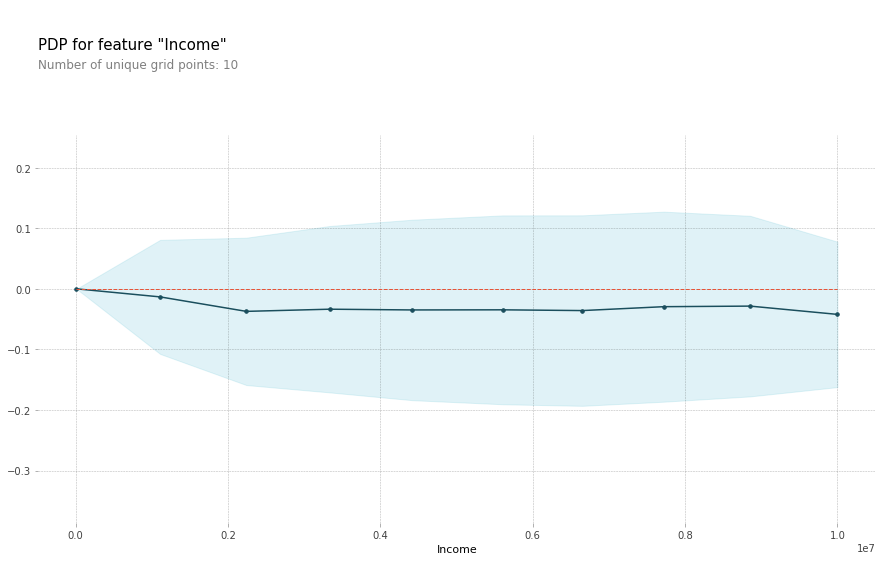

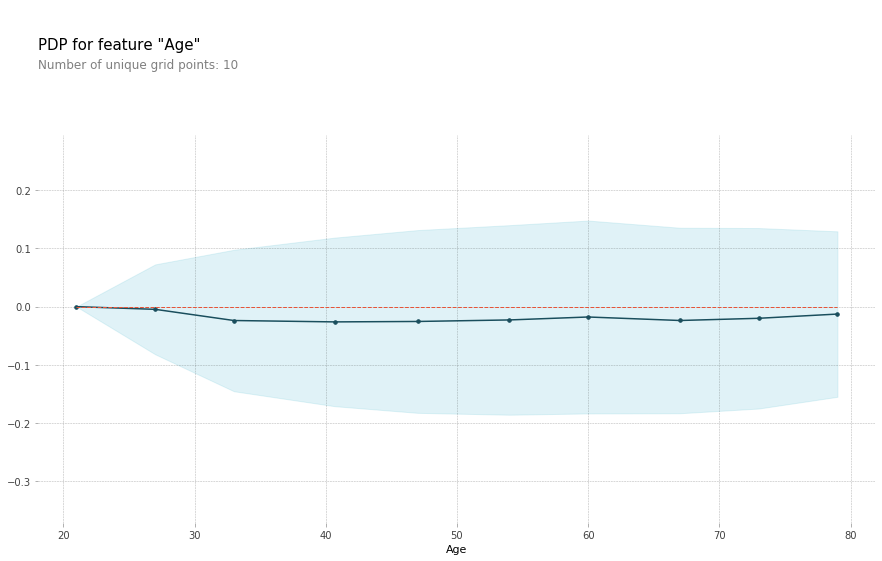

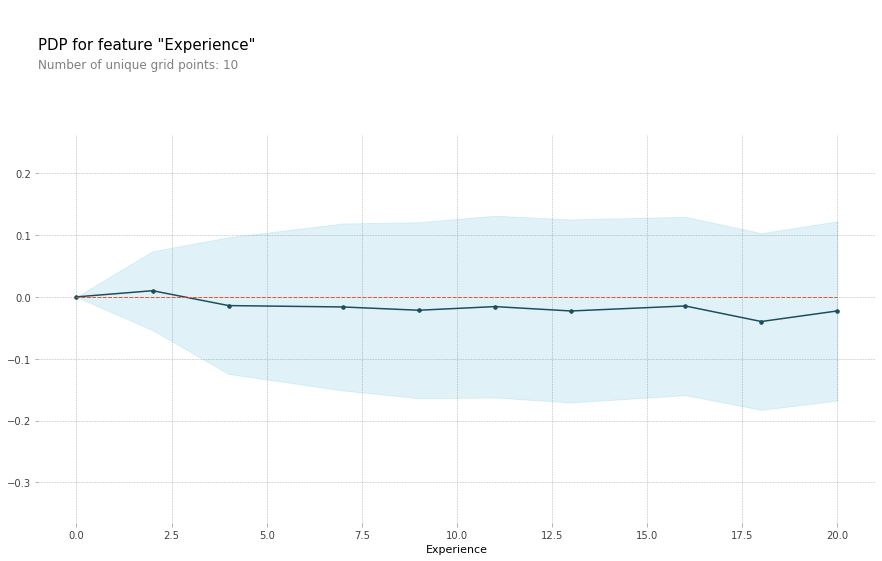

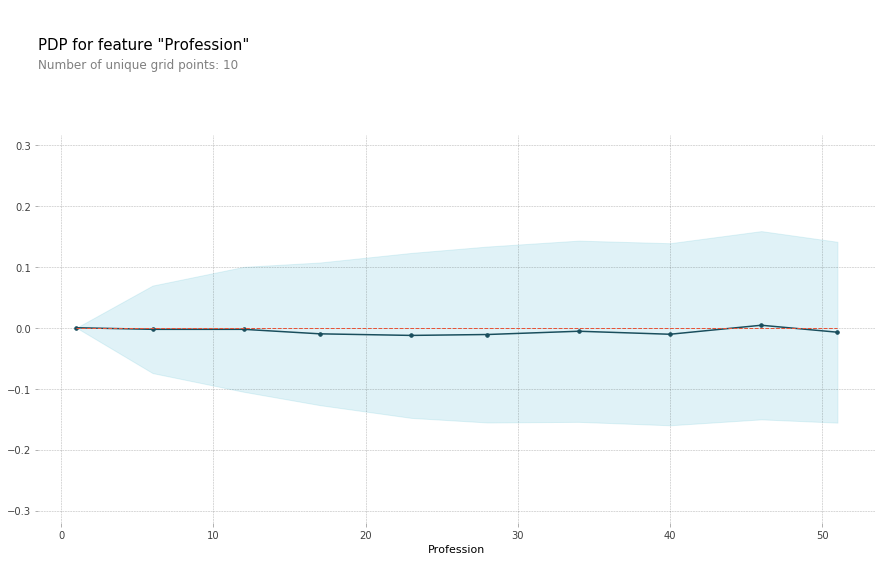

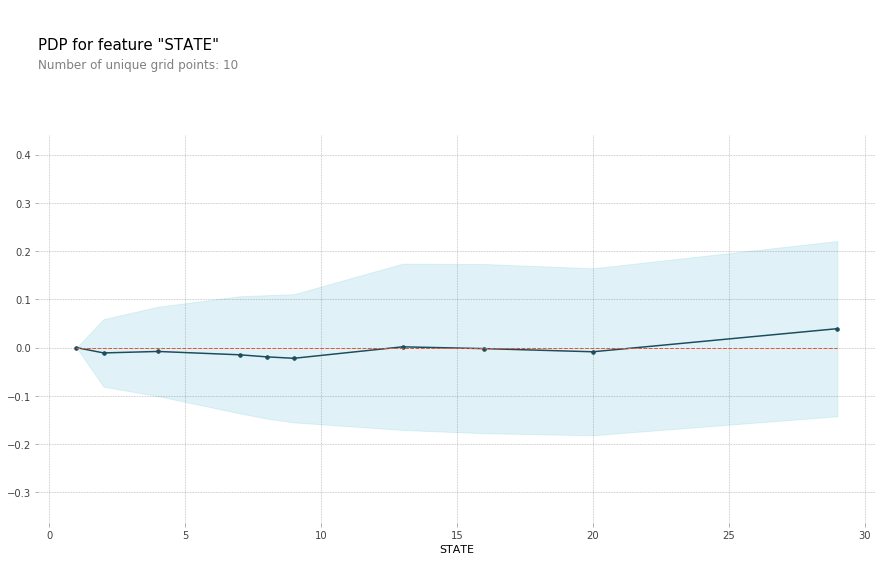

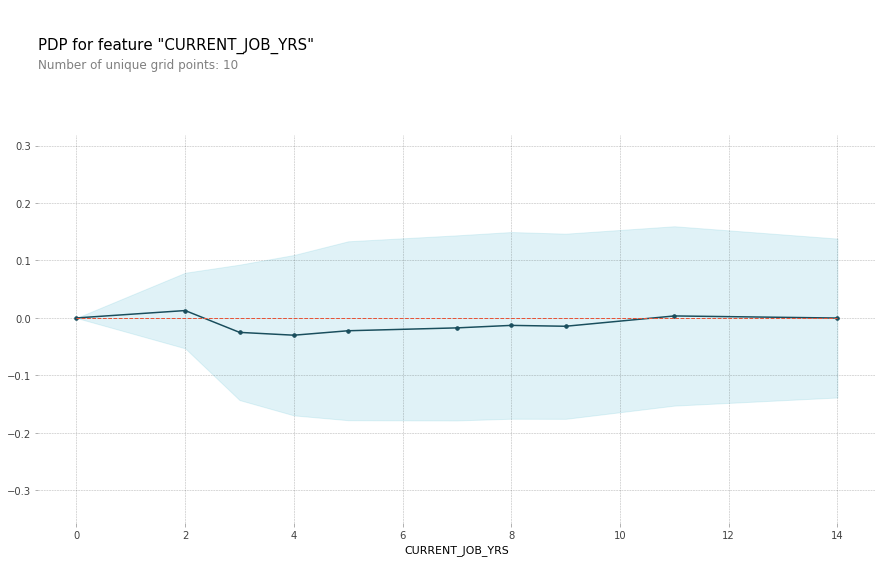

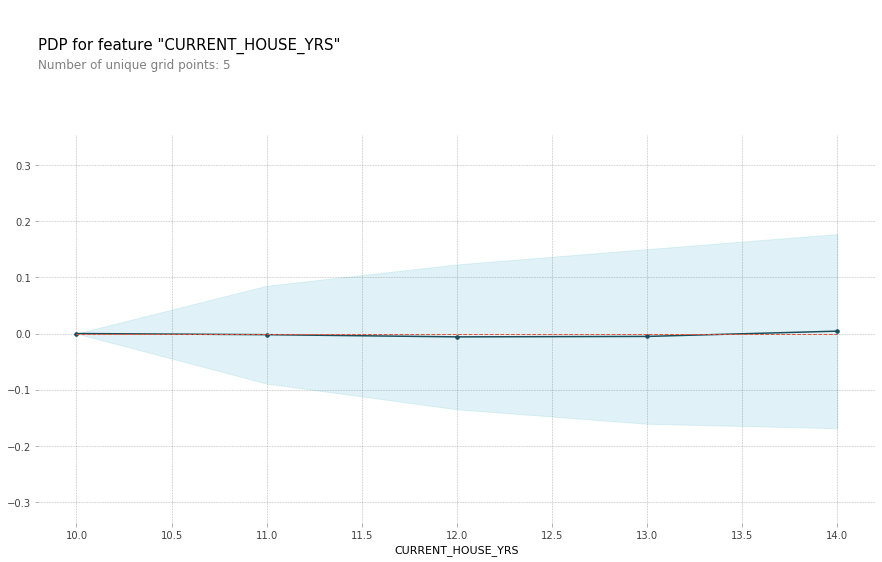

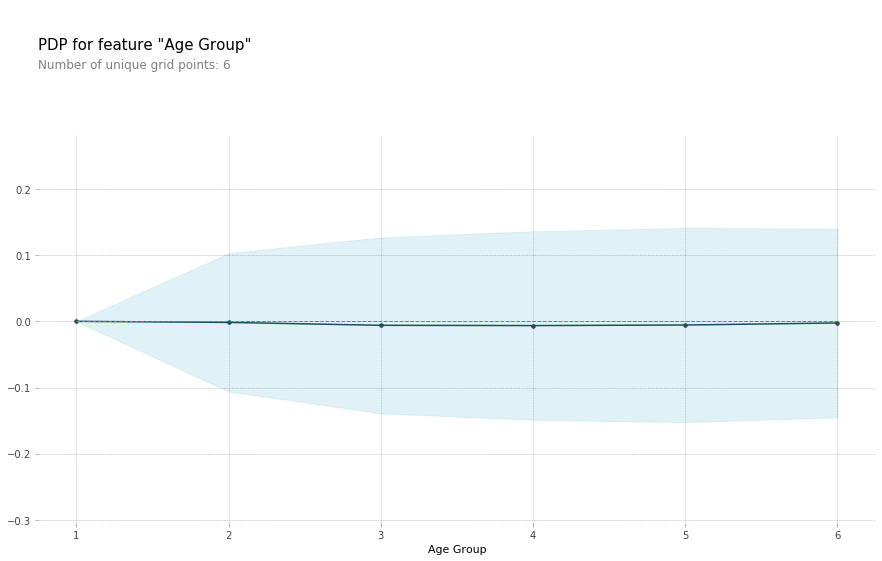

In [202]:
feature_categ1 = X_val_enc_pdp.drop(['Married/Single','Car_Ownership','House_Ownership'],axis=1).columns



for f in feature_categ1:
    isolated1 = pdp_isolate(
    model=rf_pdp, 
    dataset=X_val_enc_pdp, 
    model_features=X_val.columns, 
    feature=f,
    )
    
    pdp_plot(isolated1, feature_name=f);

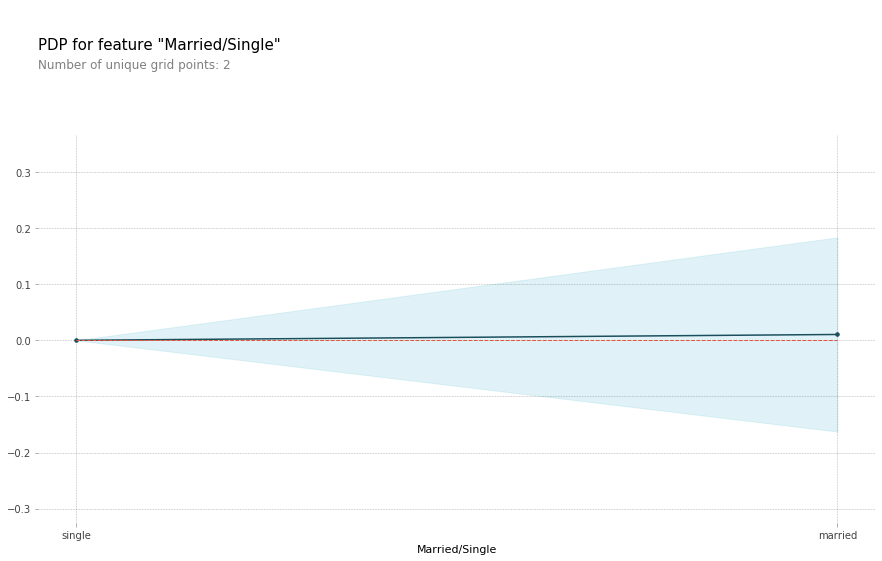

In [203]:
feature_categ2 = X_val.columns
feature1 = 'Married/Single'
pdp_dist = pdp.pdp_isolate(model=rf_pdp, 
                           dataset=X_val_enc_pdp, 
                           model_features=feature_categ2, 
                           feature=feature1)

#카테고리값 맵핑

for item in encoder.mapping:
  if item['col'] == feature1:
    feature_mapping1 = item['mapping']

feature_mapping1 = feature_mapping1[feature_mapping1.index.dropna()]
category_names1 = feature_mapping1.index.tolist()
category_codes1 = feature_mapping1.values.tolist()

#PDP

pdp.pdp_plot(pdp_dist, feature1)

plt.xticks(category_codes1, category_names1);

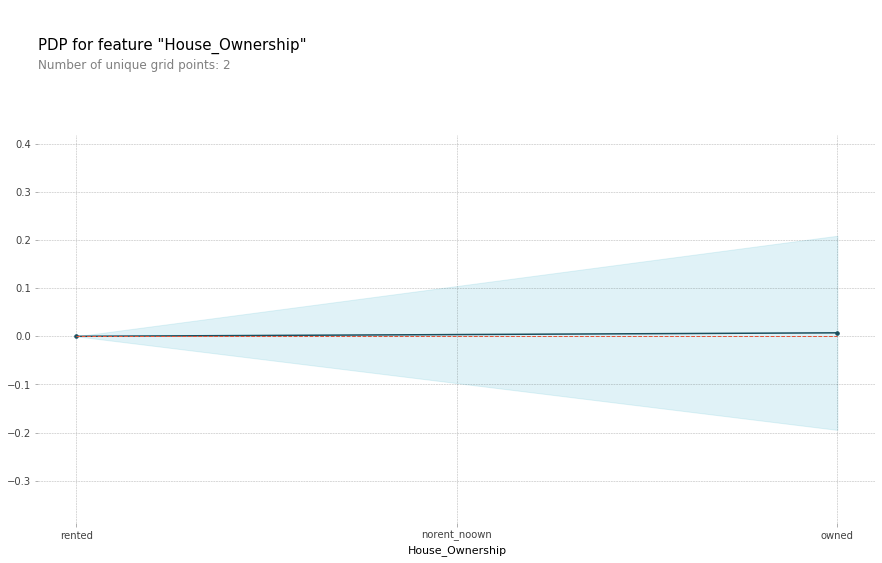

In [204]:
feature1 = 'House_Ownership'
pdp_dist = pdp.pdp_isolate(model=rf_pdp, 
                           dataset=X_val_enc_pdp, 
                           model_features=feature_categ2, 
                           feature=feature1)

#카테고리값 맵핑

for item in encoder.mapping:
  if item['col'] == feature1:
    feature_mapping1 = item['mapping']

feature_mapping1 = feature_mapping1[feature_mapping1.index.dropna()]
category_names1 = feature_mapping1.index.tolist()
category_codes1 = feature_mapping1.values.tolist()

#PDP

pdp.pdp_plot(pdp_dist, feature1)

plt.xticks(category_codes1, category_names1);

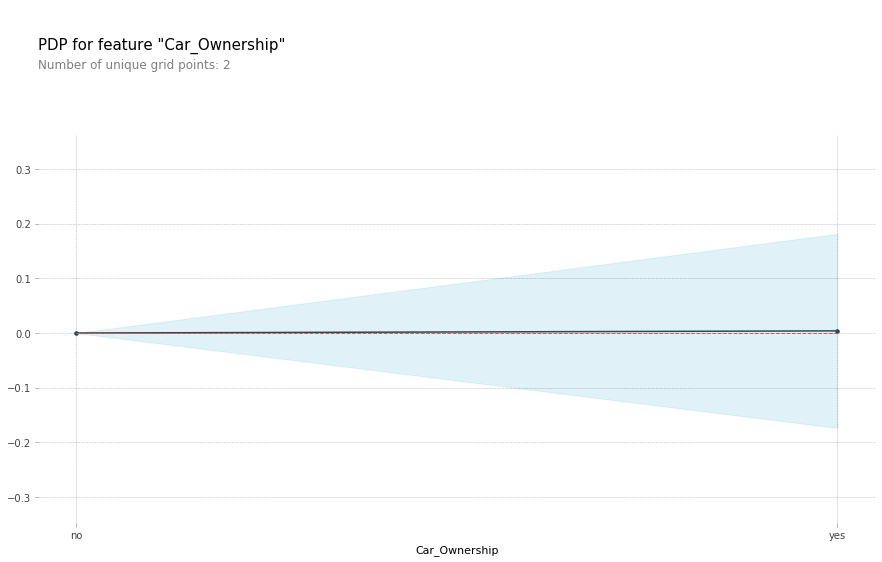

In [205]:
feature1 = 'Car_Ownership'
pdp_dist = pdp.pdp_isolate(model=rf_pdp, 
                           dataset=X_val_enc_pdp, 
                           model_features=feature_categ2, 
                           feature=feature1)

#카테고리값 맵핑

for item in encoder.mapping:
  if item['col'] == feature1:
    feature_mapping1 = item['mapping']

feature_mapping1 = feature_mapping1[feature_mapping1.index.dropna()]
category_names1 = feature_mapping1.index.tolist()
category_codes1 = feature_mapping1.values.tolist()

#PDP

pdp.pdp_plot(pdp_dist, feature1)

plt.xticks(category_codes1, category_names1);

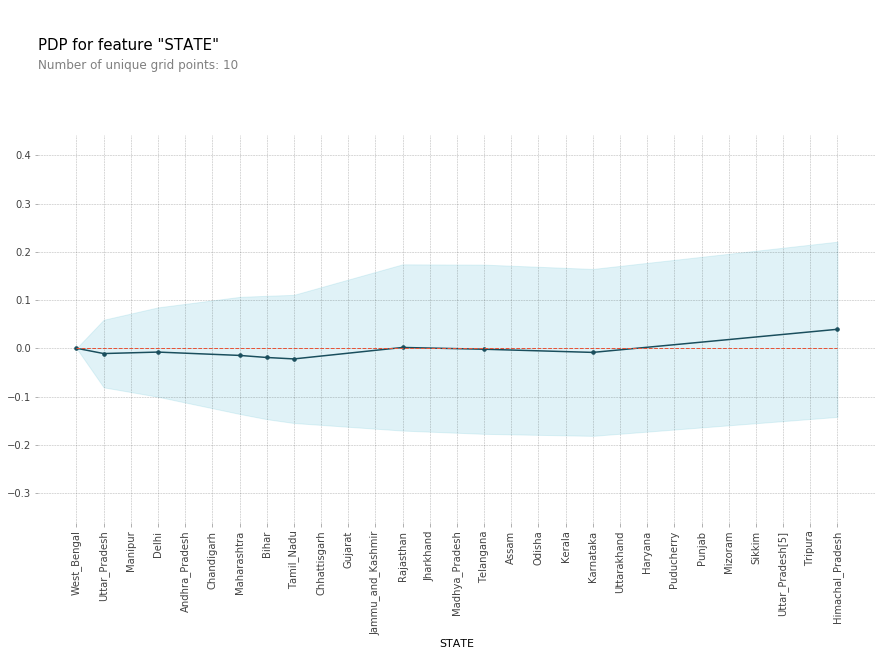

In [209]:
feature1 = 'STATE'
pdp_dist = pdp.pdp_isolate(model=rf_pdp, 
                           dataset=X_val_enc_pdp, 
                           model_features=feature_categ2, 
                           feature=feature1)

#카테고리값 맵핑

for item in encoder.mapping:
  if item['col'] == feature1:
    feature_mapping1 = item['mapping']

feature_mapping1 = feature_mapping1[feature_mapping1.index.dropna()]
category_names1 = feature_mapping1.index.tolist()
category_codes1 = feature_mapping1.values.tolist()

#PDP

pdp.pdp_plot(pdp_dist, feature1)

plt.xticks(category_codes1, category_names1, rotation=90);

In [73]:
##SHAP
import shap

explainer = shap.TreeExplainer(rf_pdp)
shpa_values = explainer.shap_values(X_val_enc_pdp.iloc[:100])

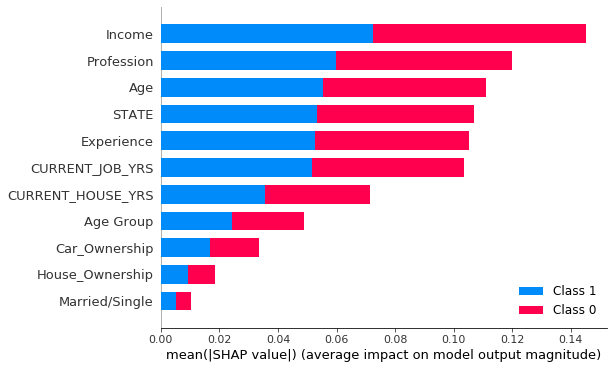

In [74]:
shap.summary_plot(shpa_values, X_val, plot_type="bar")

In [213]:
permutation

Weight,Feature
0.0107 ± 0.0023,Age
0.0073 ± 0.0029,STATE
0.0071 ± 0.0017,CURRENT_JOB_YRS
0.0068 ± 0.0028,Profession
0.0058 ± 0.0014,Income
0.0057 ± 0.0028,Experience
0.0031 ± 0.0021,CURRENT_HOUSE_YRS
0.0015 ± 0.0019,Age Group
0.0006 ± 0.0011,Married/Single
-0.0000 ± 0.0011,House_Ownership


- Permutation Importance를 통해 구한 순열 중요도와는 순위가 조금 다르나, 낮은 순위는 일치한다.
  - 낮은 순위의 특성을 제외한 모델을 최종 모델로 사용해 test data에 적용한다.

- Shap value를 보니, Permutation Importance에서 Income 특성과, Profession특성의 중요도가 낮게 평가된 것을 알 수 있다. unique value가 많아서 생긴 현상인것 같다.



---



---



# 5)

In [ ]:
##테스트 데이터에 최종모델 적용

In [ ]:
##특성 삭제한 모델

In [75]:
X_test_selected = X_test[features]

In [76]:
#class 1에 대한 성능
X_test_processed = X_test_selected
X_val_processed = X_val_selected
class_index = 1
y_pred_proba_test = best_model_randf_selected.predict_proba(X_test_processed)[:, class_index]
print(f'Test AUC for class "{best_model_randf_selected.classes_[class_index]}":')
print(roc_auc_score(y_test, y_pred_proba_test)) # 범위는 0-1, 수치는 높을 수록 좋습니다

Test AUC for class "1":
0.9364409979585021


In [77]:
y_test_pred = best_model_randf_selected.predict(X_test_processed)
print(classification_report(y_test, y_test_pred))
f1_test = f1_score(y_test, y_test_pred)
print(f'테스트 세트 f1:{f1_test}')

              precision    recall  f1-score   support

           0       0.96      0.92      0.94     22136
           1       0.55      0.75      0.64      3064

    accuracy                           0.90     25200
   macro avg       0.76      0.83      0.79     25200
weighted avg       0.91      0.90      0.90     25200

테스트 세트 f1:0.6380452788514632


In [ ]:
##특성 삭제하지 않은 모델

In [78]:
#class 1에 대한 성능

class_index = 1
y_pred_proba_test1 = best_model_randf.predict_proba(X_test)[:, class_index]
print(f'Test AUC for class "{best_model_randf.classes_[class_index]}":')
print(roc_auc_score(y_test, y_pred_proba_test1)) # 범위는 0-1, 수치는 높을 수록 좋습니다

Test AUC for class "1":
0.9367546005066237


In [79]:
y_test_pred1 = best_model_randf.predict(X_test)
print(classification_report(y_test, y_test_pred1))
f1_test1 = f1_score(y_test, y_test_pred1)
print(f'테스트 세트 f1:{f1_test1}')

              precision    recall  f1-score   support

           0       0.96      0.92      0.94     22136
           1       0.55      0.76      0.64      3064

    accuracy                           0.90     25200
   macro avg       0.76      0.84      0.79     25200
weighted avg       0.91      0.90      0.90     25200

테스트 세트 f1:0.6388429752066116


- 특성을 삭제한 모델의 test set f1 score: 0.6380
- 특성을 삭제하지 않은 모델의 test set f1 score: 0.6388

- 최종 모델은 특성을 삭제하지 않은 모델로 결정한다.

In [80]:
encoder_test = best_model_randf.named_steps['ordinalencoder']
X_test_enc = encoder_test.transform(X_test)
rf_test = best_model_randf.named_steps['randomforestclassifier']

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


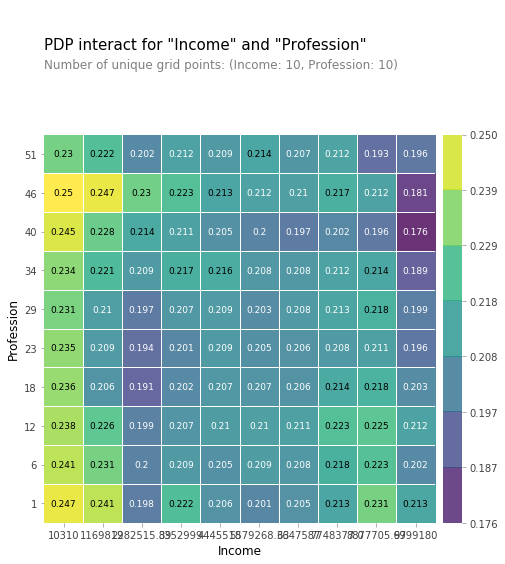

In [229]:
# 2D PDP
features_X = ['Income', 'Profession']

interaction = pdp_interact(
    model=rf_test, 
    dataset=X_test_enc, 
    model_features=X_test.columns, 
    features=features_X
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features_X);

In [82]:
explainer_test = shap.TreeExplainer(rf_test)
shpa_values_test = explainer_test.shap_values(X_test_enc.iloc[:100])

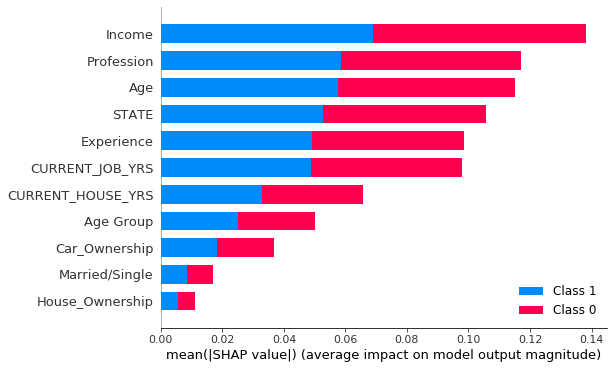

In [83]:
shap.summary_plot(shpa_values_test, X_test, plot_type="bar")

- 소득이 낮고, 직업이 46번 카테고리에 속한 사람일수록 연체할 확률이 높다는 것을 알 수 있다. (시간이 부족해 직업부분의 해석을 하지 못했다.)

- 연체할 확률에 영향을 미치는 특성에는 Income, Profession, Age등이 있다. 소득과, 직업, 나이, 사는 지역에 따라 연체할 확률이 다른 것을 알 수 있으며, 특히 Income에 큰 영향을 받는다는 것을 알 수 있다.